# Language Identification

Based on the assignment text, I have made the following assumptions:
- Document is monolingual.
- Document doesn't have code-switching and code-mixing.

It's straightforward to implement a transformer token classifier to deal with code-mixed document challenges, but I prefer sequence classification since an annotated dataset is available, and the assignment probably does not require addressing code-mixed cases.

To solve the LID problem, I decided to start with Naive Bayes classification and then try Logistic regression and finally implement a transformer-based solution. Transformer model is evidently superior to two other methods and this superiority will become more apparent as more data amasses.

## Dataset

In [ ]:
# Source : https://www.kaggle.com/datasets/basilb2s/language-detection
! gdown 1_Kyw367GJyd7TxPkeVFYbFQN1slApNI4

Downloading...
From: https://drive.google.com/uc?id=1_Kyw367GJyd7TxPkeVFYbFQN1slApNI4
To: /content/Language Detection.csv
100% 1.91M/1.91M [00:00<00:00, 219MB/s]


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('Language Detection.csv')
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [ ]:
data["Language"].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: Language, dtype: int64

In [ ]:
sentences, labels = data['Text'], data['Language']

## Naive Bayse Solution

We can use the following solution as long as the document is monolingual and code mix and switch are not involved. Naive Bayse has following benefits:
- Fast inference
- Simple
- Unaffected by rare characters

### Naive Bayse Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

model = MultinomialNB()
label_encoder = LabelEncoder()

In [ ]:
encoded_labels = label_encoder.fit_transform(labels)

### Word level featuers

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Option ‘char_wb’ creates character n-grams only from text inside word boundaries
# n-grams at the edges of words are padded with space.
# Trial and error led me to choose n-gram ranges 3-5. 
cv = CountVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=60_000)
X = cv.fit_transform(sentences).toarray()
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, encoded_labels, test_size = 0.15 , random_state = 17
    )
model.fit(train_texts, train_labels)
predictions = model.predict(X=test_texts)

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00        60
      Danish       1.00      0.93      0.96        73
       Dutch       0.98      0.97      0.97        98
     English       0.97      0.99      0.98       191
      French       0.99      1.00      1.00       145
      German       0.99      1.00      0.99        78
       Greek       1.00      1.00      1.00        51
       Hindi       1.00      1.00      1.00         5
     Italian       1.00      1.00      1.00       112
     Kannada       1.00      1.00      1.00        45
   Malayalam       1.00      1.00      1.00        86
  Portugeese       1.00      0.99      1.00       105
     Russian       1.00      0.99      1.00       105
     Spanish       0.99      0.99      0.99       142
    Sweedish       0.97      0.99      0.98       112
       Tamil       1.00      1.00      1.00        76
     Turkish       1.00      1.00      1.00        67

    accuracy              

### Inference

In [ ]:
def prediction(text, counter_vectorizer, label_encoder):
  x = counter_vectorizer.transform([text]).toarray()
  lang = model.predict(x)
  lang = label_encoder.inverse_transform(lang)
  print('Language:', lang[0])

### Right predictions
English versions of the sentence are commented above each sentence.

In [ ]:
# I am amazed how a simple solution with few data can do so well.
prediction("I am amazed how a simple solution with few data can do so well.", cv, label_encoder)

Language: English


In [ ]:
# But I wonder how hard it would be to be a multilingual code mixed case?
prediction("Pero me pregunto qué tan difícil sería ser un caso mixto de código multilingüe.", cv, label_encoder)

Language: Spanish


In [ ]:
# two man walks along the river in black coats.
prediction("दो आदमी काले कोट में नदी के किनारे चलते हैं।", cv, label_encoder)

Language: Hindi


In [ ]:
# what do you think this phrase means in other languages?
prediction("cosa pensi che significhi questa frase in altre lingue?", cv, label_encoder)

Language: Italian


In [ ]:
# And this is the last sentence which is written in Arabic.
prediction("وهذه الجملة الأخيرة مكتوبة باللغة العربية.", cv, label_encoder)

Language: Arabic


### Confusion Matrix

Text(66.5, 0.5, 'Actual')

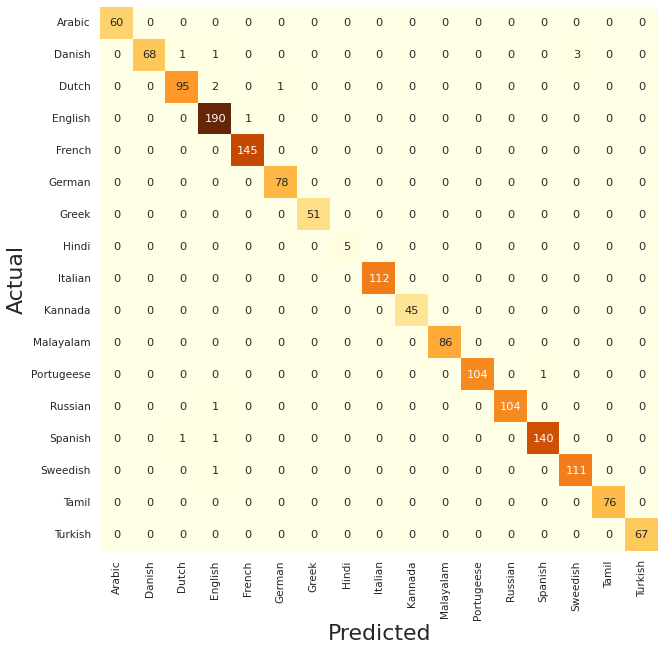

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(
    y_pred = label_encoder.inverse_transform(predictions), 
    y_true = label_encoder.inverse_transform(test_labels),
    labels = list(label_encoder.classes_)
)

conf_matrix_df = pd.DataFrame(conf_matrix, index = list(label_encoder.classes_), columns = list(label_encoder.classes_))

plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=0.95)
sns.heatmap(conf_matrix_df,cmap="YlOrBr",annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [ ]:
# Considering Colab does not have much memory, let's clear it :)
import gc
del cv
del X
del conf_matrix
del conf_matrix_df
del train_texts
del test_texts
del train_labels
del test_labels
gc.collect()

44

## Logistic Regression Solution

Both Naive Bayes and Logistic regression are linear classifiers, Logistic Regression makes a prediction for the probability using a direct functional form where as Naive Bayes figures out how the data was generated given the results.

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.15, random_state=17)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

In [ ]:
from sklearn.model_selection import GridSearchCV

logistic_classifier = GridSearchCV(pipeline, parameters, cv=5)

In [ ]:
logistic_classifier.fit(train_texts, train_labels)
predictions = logistic_classifier.predict(test_texts)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99        60
      Danish       1.00      0.90      0.95        73
       Dutch       1.00      0.93      0.96        98
     English       0.97      0.98      0.98       191
      French       0.99      0.99      0.99       145
      German       1.00      0.94      0.97        78
       Greek       1.00      0.96      0.98        51
       Hindi       1.00      1.00      1.00         5
     Italian       0.98      0.96      0.97       112
     Kannada       0.58      1.00      0.73        45
   Malayalam       1.00      1.00      1.00        86
  Portugeese       1.00      0.95      0.98       105
     Russian       0.99      0.99      0.99       105
     Spanish       0.96      0.98      0.97       142
    Sweedish       0.98      0.98      0.98       112
       Tamil       1.00      0.99      0.99        76
     Turkish       1.00      0.90      0.94        67

    accuracy              

Text(66.5, 0.5, 'Actual')

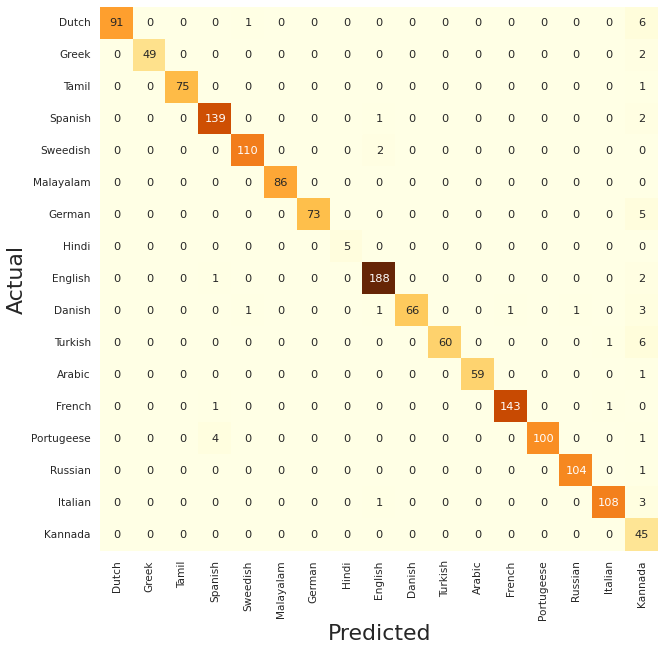

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm_labels = list(set(test_labels))

conf_matrix = confusion_matrix(
    y_pred = predictions, 
    y_true = test_labels,
    labels = cm_labels
    )

conf_matrix_df = pd.DataFrame(conf_matrix, index = cm_labels, columns = cm_labels)

plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=0.95)
sns.heatmap(conf_matrix_df, cmap="YlOrBr", annot=True, fmt='.5g', cbar=False)
plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

## Transformer Solution

In [ ]:
! pip install --quiet transformers
! pip install --quiet sentencepiece

     |████████████████████████████████| 5.3 MB 4.8 MB/s 
     |████████████████████████████████| 163 kB 85.1 MB/s 
     |████████████████████████████████| 7.6 MB 64.5 MB/s 
     |████████████████████████████████| 1.3 MB 4.8 MB/s 


### Split data into Train/Validation/Test

In [ ]:
from sklearn.model_selection import train_test_split

remain_texts, test_texts, remain_labels, test_labels = train_test_split(sentences, labels, test_size=0.15, shuffle=True, random_state=1)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(remain_texts, remain_labels, test_size=0.1, shuffle=True, random_state=1)
print(f"Train: {len(train_texts)}\nValidation: {len(valid_texts)}\nTest:  {len(test_texts)}")

Train: 7907
Validation: 879
Test:  1551


### Create label to index dictionary

In [ ]:
from pprint import pprint

target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
pprint(label2idx)

{'Arabic': 11,
 'Danish': 9,
 'Dutch': 0,
 'English': 8,
 'French': 12,
 'German': 7,
 'Greek': 1,
 'Hindi': 6,
 'Italian': 15,
 'Kannada': 16,
 'Malayalam': 2,
 'Portugeese': 13,
 'Russian': 5,
 'Spanish': 3,
 'Sweedish': 4,
 'Tamil': 14,
 'Turkish': 10}


### Preliminaries

In [ ]:
import torch

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create folder to store trained model
! mkdir model

In [ ]:
MAX_SEQ_LENGTH=100
BATCH_SIZE = 4

PRETRAINED_MODEL = 'xlm-roberta-large'
OUTPUT_DIR = "./model/"
MODEL_FILE_NAME = "LID.bin"
PATIENCE = 2

### Load Pre-Trained Model and Tokenizer

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

tokenizer = XLMRobertaTokenizer.from_pretrained(PRETRAINED_MODEL)
model = XLMRobertaForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = len(label2idx)).to(device)

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

### PyTorch Dataset

In [ ]:
class InputItem(object):

    def __init__(self, text, input_ids, input_mask, token_type_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.token_type_ids = token_type_ids
        self.label_id = label_id

In [ ]:
def process_raw_data(sentences, labels, label2idx, max_seq_length, tokenizer):
    
    input_items = []
    examples = zip(sentences, labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        token_type_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        token_type_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(token_type_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(InputItem(text=text,
                                         input_ids=input_ids,
                                         input_mask=input_mask,
                                         token_type_ids=token_type_ids,
                                         label_id=label_id))
    return input_items

In [ ]:
train_features = process_raw_data(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
valid_features = process_raw_data(valid_texts, valid_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = process_raw_data(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (2270 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_token_type_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

In [ ]:
train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
valid_dataloader = get_data_loader(valid_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### Model Training Parameters

In [ ]:
GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 4
# Since size of data is small error and trial led me to following LEARNING_RATE and BATCH_SIZE = 4

LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0
MAX_GRAD_NORM = 5
TRAINING_STEPS = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
WARMUP_STEPS = int(WARMUP_PROPORTION * TRAINING_STEPS)

### Evaluation Method

In [ ]:
import numpy as np

def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            model_outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            tmp_eval_loss, logits = model_outputs["loss"], model_outputs["logits"]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()
        
        # Store predictions and true labels
        predicted_labels.append(np.argmax(logits, axis=1))
        correct_labels.append(label_ids)

        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

        
    return eval_loss, correct_labels, predicted_labels

### Optimizer and Scheduler

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=TRAINING_STEPS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Epochs - Training

In [ ]:
import os
from tqdm import trange
from tqdm.notebook import tqdm

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        model.zero_grad()

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            # performs gradient clipping. It is used to mitigate the problem of exploding gradients,
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    valid_loss, _, _ = evaluate(model, valid_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", valid_loss)
    
    # Save the model if we got better over validation dataset.
    if len(loss_history) == 0 or valid_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    # If the PATIENCE consequential ephoch does not improve, stop the training.
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(valid_loss)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Loss history: []
Dev loss: 0.05898502299222111


Epoch:  25%|██▌       | 1/4 [05:00<15:02, 300.67s/it]

Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Loss history: [0.05898502299222111]
Dev loss: 0.03949614315411468


Epoch:  50%|█████     | 2/4 [09:56<09:55, 297.83s/it]

Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  75%|███████▌  | 3/4 [14:44<04:53, 293.12s/it]

Loss history: [0.05898502299222111, 0.03949614315411468]
Dev loss: 0.054581260920365984


Training iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  75%|███████▌  | 3/4 [19:31<06:30, 390.50s/it]

Loss history: [0.05898502299222111, 0.03949614315411468, 0.054581260920365984]
Dev loss: 0.040940116925660484
No improvement on development set. Finish training.


### Model Evaluation Metrics


In [ ]:
train_predicted

array([array([ 3, 15, 13, 13]), array([16, 14, 11, 15]),
       array([ 8,  4,  4, 15]), ..., array([5, 8, 5, 2]),
       array([ 8, 12,  1, 14]), array([ 2, 16, 16])], dtype=object)

In [ ]:
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = XLMRobertaForSequenceClassification.from_pretrained(PRETRAINED_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, valid_correct, dev_predicted = evaluate(model, valid_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(np.concatenate(train_correct, axis=0), np.concatenate(train_predicted, axis=0), average="micro"))
print("Validation performance:", precision_recall_fscore_support(np.concatenate(valid_correct, axis=0), np.concatenate(dev_predicted, axis=0), average="micro"))
print("Test performance:", precision_recall_fscore_support(np.concatenate(test_correct, axis=0), np.concatenate(test_predicted, axis=0), average="micro"))

bert_accuracy = np.mean(test_predicted.flatten() == test_correct.flatten())

print(classification_report(np.concatenate(test_correct, axis=0), np.concatenate(test_predicted, axis=0), target_names=target_names))

Evaluation iteration:   0%|          | 0/1977 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Evaluation iteration:   0%|          | 0/220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/388 [00:00<?, ?it/s]

Training performance: (0.9962058935120779, 0.9962058935120779, 0.9962058935120779, None)
Validation performance: (0.9943117178612059, 0.9943117178612059, 0.9943117178612059, None)
Test performance: (0.9929078014184397, 0.9929078014184397, 0.9929078014184397, None)
              precision    recall  f1-score   support

       Dutch       0.98      1.00      0.99        84
       Greek       1.00      1.00      1.00        50
   Malayalam       1.00      1.00      1.00        79
     Spanish       0.99      0.97      0.98       112
    Sweedish       1.00      0.99      1.00       101
     Russian       1.00      1.00      1.00       101
       Hindi       1.00      1.00      1.00        12
      German       1.00      1.00      1.00        65
     English       1.00      1.00      1.00       229
      Danish       0.99      1.00      0.99        70
     Turkish       1.00      1.00      1.00        63
      Arabic       1.00      1.00      1.00        78
      French       1.00      0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
